# Vanilla RNNs, GRUs and the `scan` function

In this notebook, you will learn how to define the forward method for vanilla RNNs and GRUs. Additionally, you will see how to define and use the function `scan` to compute forward propagation for RNNs.

By completing this notebook, you will:

- Be able to define the forward method for vanilla RNNs and GRUs
- Be able to define the `scan` function to perform forward propagation for RNNs
- Understand how forward propagation is implemented for RNNs.

In [1]:
import numpy as np
from numpy import random
from time import perf_counter

An implementation of the `sigmoid` function is provided below so you can use it in this notebook.

In [2]:
def sigmoid(x): # Sigmoid function
    return 1.0 / (1.0 + np.exp(-x))

# Part 1: Forward method for vanilla RNNs and GRUs

In this part of the notebook, you'll see the implementation of the forward method for a vanilla RNN and you'll implement that same method for a GRU. For this exercise you'll use a set of random weights and variables with the following dimensions:

- Embedding size (`emb`) : 128
- Hidden state size (`h_dim`) : 16

The weights `w_` and biases `b_` are initialized with dimensions (`h_dim`, `emb + h_dim`) and (`h_dim`, 1). We expect the hidden state `h_t` to be a column vector with size (`h_dim`,1) and the initial hidden state `h_0` is a vector of zeros.

In [3]:
random.seed(10)                 # Random seed, so your results match ours
emb = 128                       # Embedding size
T = 256                         # Number of variables in the sequences
h_dim = 16                      # Hidden state dimension
h_0 = np.zeros((h_dim, 1))      # Initial hidden state
# Random initialization of weights and biases
w1 = random.standard_normal((h_dim, emb+h_dim))
w2 = random.standard_normal((h_dim, emb+h_dim))
w3 = random.standard_normal((h_dim, emb+h_dim))
b1 = random.standard_normal((h_dim, 1))
b2 = random.standard_normal((h_dim, 1))
b3 = random.standard_normal((h_dim, 1))
X = random.standard_normal((T, emb, 1))
weights = [w1, w2, w3, b1, b2, b3]

## 1.1 Forward method for vanilla RNNs

The vanilla RNN cell is quite straight forward. Its most general structure is presented in the next figure: 

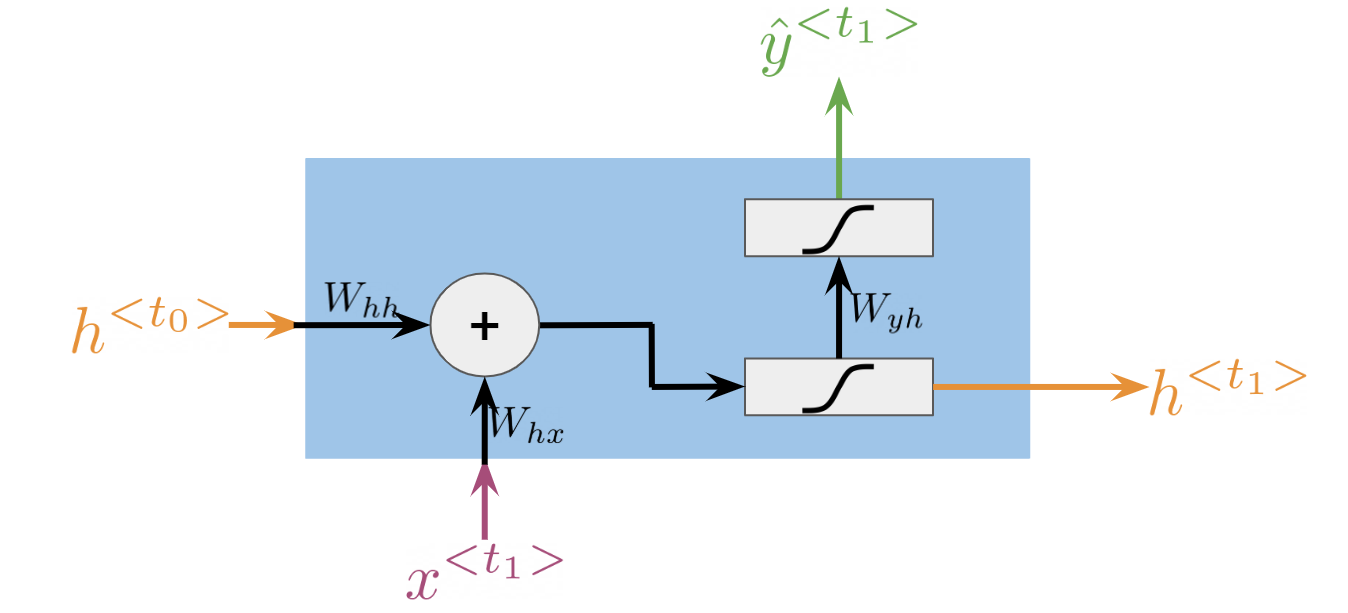

As you saw in the lecture videos, the computations made in a vanilla RNN cell are equivalent to the following equations:

\begin{align}
h^{<t>} &= g(W_{h}[h^{<t-1>},x^{<t>}] + b_h) \tag{htRNN} \\
\hat{y}^{<t>} &= g(W_{yh}h^{<t>} + b_y) \tag{ytRNN}
\end{align}

where $[h^{<t-1>},x^{<t>}]$ means that $h^{<t-1>}$ and $x^{<t>}$ are concatenated together. In the next cell we provide the implementation of the forward method for a vanilla RNN. 

In [4]:
def forward_V_RNN(inputs, weights): # Forward propagation for a a single vanilla RNN cell
    x, h_t = inputs

    # weights.
    wh, _, _, bh, _, _ = weights

    # new hidden state
    h_t = np.dot(wh, np.concatenate([h_t, x])) + bh
    h_t = sigmoid(h_t)

    return h_t, h_t

As you can see, we omitted the computation of $\hat{y}^{<t>}$. This was done for the sake of simplicity, so you can focus on the way that hidden states are updated here and in the GRU cell.

## 1.2 Forward method for GRUs

A GRU cell have more computations than the ones that vanilla RNNs have. You can see this visually in the following diagram:

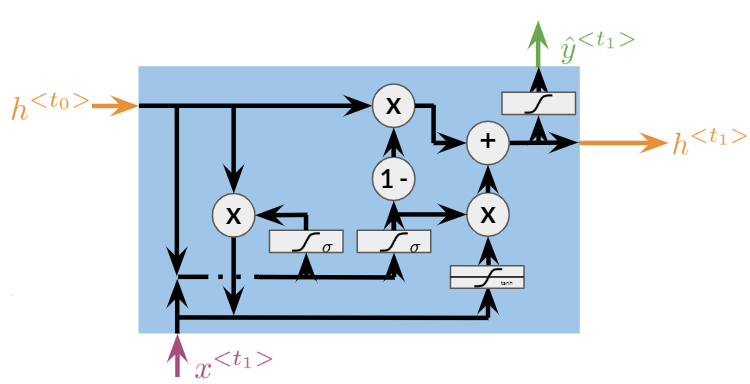

As you saw in the lecture videos, GRUs have relevance $\Gamma_r$ and update $\Gamma_u$ gates that control how the hidden state $h^{<t>}$ is updated on every time step. With these gates, GRUs are capable of keeping relevant information in the hidden state even for long sequences. The equations needed for the forward method in GRUs are provided below: 

\begin{equation}
\Gamma_r=\sigma{(W_r[h^{<t-1>}, x^{<t>}]+b_r)}
\end{equation}

\begin{equation}
\Gamma_u=\sigma{(W_u[h^{<t-1>}, x^{<t>}]+b_u)}
\end{equation}

\begin{equation}
c^{<t>}=\tanh{(W_h[\Gamma_r*h^{<t-1>},x^{<t>}]+b_h)}
\end{equation}

\begin{equation}
h^{<t>}=\Gamma_u*c^{<t>}+(1-\Gamma_u)*h^{<t-1>}
\end{equation}

In the next cell, you will see the implementation of the forward method for a GRU cell by computing the update `u` and relevance `r` gates, and the candidate hidden state `c`. 

In [5]:
def forward_GRU(inputs, weights): # Forward propagation for a single GRU cell
    x, h_t = inputs

    # weights.
    wu, wr, wc, bu, br, bc = weights

    # Update gate
    ### START CODE HERE (1-2 lINES) ###
    u = np.dot(wu, np.concatenate([h_t, x])) + bu
    u = sigmoid(u)
    ### END CODE HERE ###
    
    # Relevance gate
    ### START CODE HERE (1-2 lINES) ###
    r = np.dot(wr, np.concatenate([h_t, x])) + br
    r = sigmoid(r)
    ### END CODE HERE ###
    
    # Candidate hidden state 
    ### START CODE HERE (1-2 lINES) ###
    c = np.dot(wc, np.concatenate([r * h_t, x])) + bc
    c = np.tanh(c)
    ### END CODE HERE ###
    
    # New Hidden state h_t
    h_t = u* c + (1 - u)* h_t
    return h_t, h_t

Run the following cell to check your implementation.

In [6]:
forward_GRU([X[1],h_0], weights)[0]

array([[ 9.77779014e-01],
       [-9.97986240e-01],
       [-5.19958083e-01],
       [-9.99999886e-01],
       [-9.99707004e-01],
       [-3.02197037e-04],
       [-9.58733503e-01],
       [ 2.10804828e-02],
       [ 9.77365398e-05],
       [ 9.99833090e-01],
       [ 1.63200940e-08],
       [ 8.51874303e-01],
       [ 5.21399924e-02],
       [ 2.15495959e-02],
       [ 9.99878828e-01],
       [ 9.77165472e-01]])

Expected output:
<pre>
array([[ 9.77779014e-01],
       [-9.97986240e-01],
       [-5.19958083e-01],
       [-9.99999886e-01],
       [-9.99707004e-01],
       [-3.02197037e-04],
       [-9.58733503e-01],
       [ 2.10804828e-02],
       [ 9.77365398e-05],
       [ 9.99833090e-01],
       [ 1.63200940e-08],
       [ 8.51874303e-01],
       [ 5.21399924e-02],
       [ 2.15495959e-02],
       [ 9.99878828e-01],
       [ 9.77165472e-01]])
</pre>

# Part 2: Implementation of the `scan` function

In the lectures you saw how the `scan` function is used for forward propagation in RNNs. It takes as inputs:

- `fn` : the function to be called recurrently (i.e. `forward_GRU`)
- `elems` : the list of inputs for each time step (`X`)
- `weights` : the parameters needed to compute `fn`
- `h_0` : the initial hidden state

`scan` goes through all the elements `x` in `elems`, calls the function `fn` with arguments ([`x`, `h_t`],`weights`), stores the computed hidden state `h_t` and appends the result to a list `ys`. Complete the following cell by calling `fn` with arguments ([`x`, `h_t`],`weights`).

In [7]:
def scan(fn, elems, weights, h_0=None): # Forward propagation for RNNs
    h_t = h_0
    ys = []
    for x in elems:
        ### START CODE HERE (1 lINE) ###
        y, h_t = fn([x, h_t], weights)
        ### END CODE HERE ###
        ys.append(y)
    return ys, h_t

# Part 3: Comparison between vanilla RNNs and GRUs

You have already seen how forward propagation is computed for vanilla RNNs and GRUs. As a quick recap, you need to have a forward method for the recurrent cell and a function like `scan` to go through all the elements from a sequence using a forward method. You saw that GRUs performed more computations than vanilla RNNs, and you can check that they have 3 times more parameters. In the next two cells, we compute forward propagation for a sequence with 256 time steps (`T`) for an RNN and a GRU with the same hidden state `h_t` size (`h_dim`=16).  

In [ ]:
# vanilla RNNs
tic = perf_counter()
ys, h_T = scan(forward_V_RNN, X, weights, h_0)
toc = perf_counter()
RNN_time=(toc-tic)*1000
print (f"It took {RNN_time:.2f}ms to run the forward method for the vanilla RNN.")

In [9]:
# GRUs
tic = perf_counter()
ys, h_T = scan(forward_GRU, X, weights, h_0)
toc = perf_counter()
GRU_time=(toc-tic)*1000
print (f"It took {GRU_time:.2f}ms to run the forward method for the GRU.")

It took 20.02ms to run the forward method for the GRU.


As you were told in the lectures, GRUs take more time to compute (However, sometimes, although a rare occurrence, Vanilla RNNs take more time. Can you figure out what might cause this ?). This means that training and prediction would take more time for a GRU than for a vanilla RNN. However, GRUs allow you to propagate relevant information even for long sequences, so when selecting an architecture for NLP you should assess the tradeoff between computational time and performance. 

<b>Congratulations!</b> Now you know how the forward method is implemented for vanilla RNNs and GRUs, and you know how the scan function provides an abstraction for forward propagation in RNNs. 